# Interfaces

In Nipype, interfaces are python modules that allow you to use various external packages (e.g. FSL, SPM or FreeSurfer), even if they themselves are written in another programming language than python. Such an interface knows what sort of options an external program has and how to execute it.

To illustrate why interfaces are so useful, let's have a look at the brain extraction algorithm [BET](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET) from FSL. Once in its original framework and once in the Nipype framework.

## BET in the origional framework

Let's take a look at one of the T1 images we have in our dataset on which we want to run BET.

Populating the interactive namespace from numpy and matplotlib


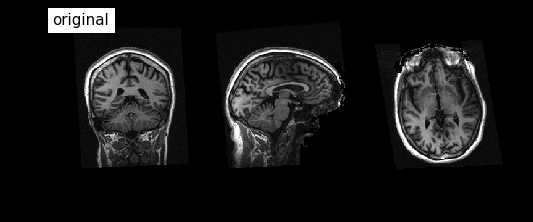

In [2]:
%pylab inline
from nilearn.plotting import plot_anat
plot_anat('/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz', title='original',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

In its simplest form, you can run BET by just specifying the input image and tell it what to name the output image:

    bet <input> <output>

In [3]:
%%bash

FILENAME=/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w

bet ${FILENAME}.nii.gz /output/sub-01_ses-test_T1w_bet.nii.gz

Let's take a look at the results:

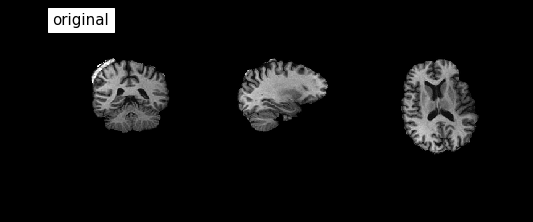

In [4]:
plot_anat('/output/sub-01_ses-test_T1w_bet.nii.gz', title='original',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

Perfect! Exactly what we want. Hmm... what else could we want from BET? Well, it's actually a fairly complicated program. As is the case for all FSL binaries, just call it with no arguments to see all its options.

In [5]:
%%bash
bet


Usage:    bet <input> <output> [options]

Main bet2 options:
  -o          generate brain surface outline overlaid onto original image
  -m          generate binary brain mask
  -s          generate approximate skull image
  -n          don't generate segmented brain image output
  -f <f>      fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates
  -g <g>      vertical gradient in fractional intensity threshold (-1->1); default=0; positive values give larger brain outline at bottom, smaller at top
  -r <r>      head radius (mm not voxels); initial surface sphere is set to half of this
  -c <x y z>  centre-of-gravity (voxels not mm) of initial mesh surface.
  -t          apply thresholding to segmented brain image and mask
  -e          generates brain surface as mesh in .vtk format

Variations on default bet2 functionality (mutually exclusive options):
  (default)   just run bet2
  -R          robust brain centre estimation (iterates BE

We see that BET can also return a binary brain mask as a result of the skull-strip, which can be useful for masking our GLM analyses (among other things). Let's run it again including that option and see the result.

In [6]:
%%bash

FILENAME=/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w

bet ${FILENAME}.nii.gz /output/sub-01_ses-test_T1w_bet.nii.gz -m

/opt/conda/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:481: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


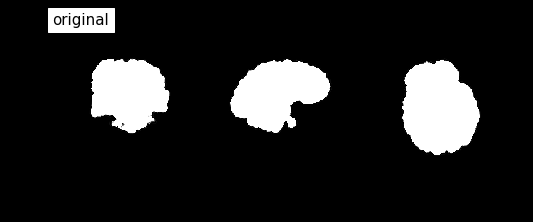

In [7]:
plot_anat('/output/sub-01_ses-test_T1w_bet_mask.nii.gz', title='original',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

Now let's look at the BET interface in Nipype. First, we have to import it.

## BET in the Nipype framework

So how can we run BET in the Nipype framework?

First things first, we need to import the ``BET`` class from Nipype's ``interfaces`` module:

In [8]:
from nipype.interfaces.fsl import BET

Now that we have the BET function accessible, we just have to specify the input and output file. And finally we have to run the command. So exactly like in the original framework.

In [9]:
skullstrip = BET()
skullstrip.inputs.in_file = "/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz"
skullstrip.inputs.out_file = "/output/T1w_nipype_bet.nii.gz"
res = skullstrip.run()

If we now look at the results from Nipype, we see that it is exactly the same as before.

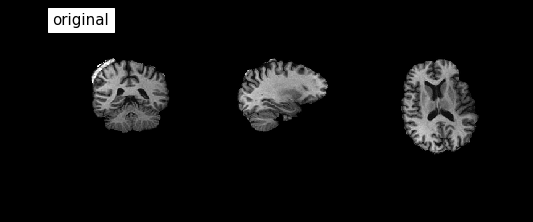

In [10]:
plot_anat('/output/T1w_nipype_bet.nii.gz', title='original',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

This is not surprising, because Nipype used exactly the same bash code that we were using in the original framework example above. To verify this, we can call the ``cmdline`` function of the constructed BET instance.

In [11]:
print(skullstrip.cmdline)

bet /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz /output/T1w_nipype_bet.nii.gz


Another way to set the inputs on an interface object is to use them as keyword arguments when you construct the interface instance. Let's write the Nipype code from above in this way, but let's also add the option to create a brain mask.

In [12]:
skullstrip = BET(in_file="/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz",
                 out_file="/output/T1w_nipype_bet.nii.gz",
                 mask=True)
res = skullstrip.run()

Now if we plot this, we see again that this worked exactly as before. No surprise there.

/opt/conda/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:481: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


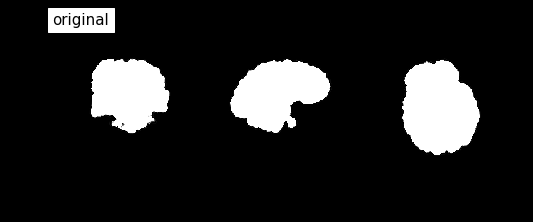

In [13]:
plot_anat('/output/T1w_nipype_bet_mask.nii.gz', title='after skullstrip',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

## Help Function

But how did we know what the names of the input parameters are? In the original framework we were able to just run ``BET``, without any additional parameters to get an information page. In the Nipype framework we can achieve the same thing by using the ``help()`` function on an interface class. For the BET example, this is:

In [14]:
BET.help()

Wraps command **bet**

Use FSL BET command for skull stripping.

For complete details, see the `BET Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> btr = fsl.BET()
>>> btr.inputs.in_file = 'structural.nii'
>>> btr.inputs.frac = 0.7
>>> btr.inputs.out_file = 'brain_anat.nii'
>>> btr.cmdline
'bet structural.nii brain_anat.nii -f 0.70'
>>> res = btr.run() # doctest: +SKIP

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		input file to skull strip
		flag: %s, position: 0

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	center: (a list of at most 3 items which are an integer (int or
		 long))
		center of gravity in voxels
		flag: -c %s
	environ: (a dictionary with keys which are a bytes or None or a value
		 of class 'str' and with values which are a bytes or None or a value
		 of class 'str', nipype default value: {})
		Environment variables
	frac: (a floa

As you can see, we get three different informations. ***First***, a general explanation of the class.

    Wraps command **bet**

    Use FSL BET command for skull stripping.

    For complete details, see the `BET Documentation.
    <http://www.fmrib.ox.ac.uk/fsl/bet2/index.html>`_

    Examples
    --------
    >>> from nipype.interfaces import fsl
    >>> from nipype.testing import  example_data
    >>> btr = fsl.BET()
    >>> btr.inputs.in_file = example_data('structural.nii')
    >>> btr.inputs.frac = 0.7
    >>> res = btr.run() # doctest: +SKIP

***Second***, a list of all possible input parameters.

    Inputs::

        [Mandatory]
        in_file: (an existing file name)
            input file to skull strip
            flag: %s, position: 0

        [Optional]
        args: (a string)
            Additional parameters to the command
            flag: %s
        center: (a list of at most 3 items which are an integer (int or
             long))
            center of gravity in voxels
            flag: -c %s
        environ: (a dictionary with keys which are a value of type 'str' and
             with values which are a value of type 'str', nipype default value:
             {})
            Environment variables
        frac: (a float)
            fractional intensity threshold
            flag: -f %.2f
        functional: (a boolean)
            apply to 4D fMRI data
            flag: -F
            mutually_exclusive: functional, reduce_bias, robust, padding,
             remove_eyes, surfaces, t2_guided
        ignore_exception: (a boolean, nipype default value: False)
            Print an error message instead of throwing an exception in case the
            interface fails to run
        mask: (a boolean)
            create binary mask image
            flag: -m
        mesh: (a boolean)
            generate a vtk mesh brain surface
            flag: -e
        no_output: (a boolean)
            Don't generate segmented output
            flag: -n
        out_file: (a file name)
            name of output skull stripped image
            flag: %s, position: 1
        outline: (a boolean)
            create surface outline image
            flag: -o
        output_type: ('NIFTI_PAIR' or 'NIFTI_PAIR_GZ' or 'NIFTI_GZ' or
             'NIFTI')
            FSL output type
        padding: (a boolean)
            improve BET if FOV is very small in Z (by temporarily padding end
            slices)
            flag: -Z
            mutually_exclusive: functional, reduce_bias, robust, padding,
             remove_eyes, surfaces, t2_guided
        radius: (an integer (int or long))
            head radius
            flag: -r %d
        reduce_bias: (a boolean)
            bias field and neck cleanup
            flag: -B
            mutually_exclusive: functional, reduce_bias, robust, padding,
             remove_eyes, surfaces, t2_guided
        remove_eyes: (a boolean)
            eye & optic nerve cleanup (can be useful in SIENA)
            flag: -S
            mutually_exclusive: functional, reduce_bias, robust, padding,
             remove_eyes, surfaces, t2_guided
        robust: (a boolean)
            robust brain centre estimation (iterates BET several times)
            flag: -R
            mutually_exclusive: functional, reduce_bias, robust, padding,
             remove_eyes, surfaces, t2_guided
        skull: (a boolean)
            create skull image
            flag: -s
        surfaces: (a boolean)
            run bet2 and then betsurf to get additional skull and scalp surfaces
            (includes registrations)
            flag: -A
            mutually_exclusive: functional, reduce_bias, robust, padding,
             remove_eyes, surfaces, t2_guided
        t2_guided: (a file name)
            as with creating surfaces, when also feeding in non-brain-extracted
            T2 (includes registrations)
            flag: -A2 %s
            mutually_exclusive: functional, reduce_bias, robust, padding,
             remove_eyes, surfaces, t2_guided
        terminal_output: ('stream' or 'allatonce' or 'file' or 'none')
            Control terminal output: `stream` - displays to terminal immediately
            (default), `allatonce` - waits till command is finished to display
            output, `file` - writes output to file, `none` - output is ignored
        threshold: (a boolean)
            apply thresholding to segmented brain image and mask
            flag: -t
        vertical_gradient: (a float)
            vertical gradient in fractional intensity threshold (-1, 1)
            flag: -g %.2f

And ***third***, a list of all possible output parameters.

    Outputs::

        inskull_mask_file: (a file name)
            path/name of inskull mask (if generated)
        inskull_mesh_file: (a file name)
            path/name of inskull mesh outline (if generated)
        mask_file: (a file name)
            path/name of binary brain mask (if generated)
        meshfile: (a file name)
            path/name of vtk mesh file (if generated)
        out_file: (a file name)
            path/name of skullstripped file (if generated)
        outline_file: (a file name)
            path/name of outline file (if generated)
        outskin_mask_file: (a file name)
            path/name of outskin mask (if generated)
        outskin_mesh_file: (a file name)
            path/name of outskin mesh outline (if generated)
        outskull_mask_file: (a file name)
            path/name of outskull mask (if generated)
        outskull_mesh_file: (a file name)
            path/name of outskull mesh outline (if generated)
        skull_mask_file: (a file name)
            path/name of skull mask (if generated)

So here we see that Nipype also has output parameters. This is very practical. Because instead of typing the full path name to the mask volume, we can also more directly use the ``mask_file`` parameter.

In [15]:
print(res.outputs.mask_file)

/home/neuro/nipype_tutorial/notebooks/T1w_nipype_bet_mask.nii.gz


## Interface errors

To execute any interface class we use the ``run`` method on that object. For FSL, Freesurfer, and other programs, this will just make a system call with the command line we saw above. For MATLAB-based programs like SPM, it will actually generate a ``.m`` file and run a MATLAB process to execute it. All of that is handled in the background.

But what happens if we didn't specify all necessary inputs? For instance, you need to give BET a file to work on. If you try and run it without setting the input ``in_file``, you'll get a Python exception before anything actually gets executed:

In [16]:
skullstrip2 = BET()
try:
    skullstrip2.run()
except(ValueError) as err:
    print("ValueError:", err)
else:
    raise

ValueError: BET requires a value for input 'in_file'. For a list of required inputs, see BET.help()


Nipype also knows some things about what sort of values should get passed to the inputs, and will raise (hopefully) informative exceptions when they are violated -- before anything gets processed. For example, BET just lets you say "create a mask," it doesn't let you name it. You may forget this, and try to give it a name. In this case, Nipype will raise a ``TraitError`` telling you what you did wrong:

In [17]:
try:
    skullstrip.inputs.mask = "mask_file.nii"
except(Exception) as err:
    if "TraitError" in str(err.__class__):
        print("TraitError:", err)
    else:
        raise
else:
    raise

TraitError: The 'mask' trait of a BETInputSpec instance must be a boolean, but a value of 'mask_file.nii' <class 'str'> was specified.


Additionally, Nipype knows that, for inputs corresponding to files you are going to process, they should exist in your file system. If you pass a string that doesn't correspond to an existing file, it will error and let you know:

In [18]:
try:
    skullstrip.inputs.in_file = "/data/oops_a_typo.nii"
except(Exception) as err:
    if "TraitError" in str(err.__class__):
        print("TraitError:", err)
    else:
        raise
else:
    raise

TraitError: The trait 'in_file' of a BETInputSpec instance is an existing file name, but the path  '/data/oops_a_typo.nii' does not exist.


It turns out that for default output files, you don't even need to specify a name. Nipype will know what files are going to be created and will generate a name for you:

In [19]:
skullstrip = BET(in_file="/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz")
print(skullstrip.cmdline)

bet /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz /home/neuro/nipype_tutorial/notebooks/sub-01_ses-test_T1w_brain.nii.gz


Note that it is going to write the output file to the local directory.

What if you just ran this interface and wanted to know what it called the file that was produced? As you might have noticed before, calling the ``run`` method returned an object called ``InterfaceResult`` that we saved under the variable ``res``.  Let's inspect that object:

In [20]:
res = skullstrip.run()
print(res.outputs)


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = <undefined>
meshfile = <undefined>
out_file = /home/neuro/nipype_tutorial/notebooks/sub-01_ses-test_T1w_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>



We see that four possible files can be generated by BET. Here we ran it in the most simple way possible, so it just generated an ``out_file``, which is the skull-stripped image. Let's see what happens when we generate a mask. By the way, you can also set inputs at runtime by including them as arguments to the ``run`` method:

In [21]:
res2 = skullstrip.run(mask=True)
print(res2.outputs)


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/neuro/nipype_tutorial/notebooks/sub-01_ses-test_T1w_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/neuro/nipype_tutorial/notebooks/sub-01_ses-test_T1w_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>



Nipype knows that if you ask for a mask, BET is going to generate it in a particular way and makes that information available to you.

## Why this is amazing!

**A major motivating objective for Nipype is to streamline the integration of different analysis packages, so that you can use the algorithms you feel are best suited to your particular problem.**

Say that you want to use BET, as SPM does not offer a way to create an explicit mask from functional data, but that otherwise you want your processing to occur in SPM. Although possible to do this in a MATLAB script, it might not be all that clean, particularly if you want your skullstrip to happen in the middle of your workflow (for instance, after realignment). Nipype provides a unified representation of interfaces across analysis packages.

For more on this, check out the [Interfaces](basic_interfaces.ipynb) and the [Workflow](basic_workflow.ipynb) tutorial.

#### Exercise 1a
Import `IsotropicSmooth` from `nipype.interfaces.fsl` and find  the `FSL` command that is being run. What are the mandatory inputs for this interface?

In [1]:
from nipype.interfaces.fsl import IsotropicSmooth
# all this information can be found when we run `help` method. 
# note that you can either provide `in_file` and `fwhm` or `in_file` and `sigma`
IsotropicSmooth.help()

Wraps command **fslmaths**

Use fslmaths to spatially smooth an image with a gaussian kernel.

Inputs::

	[Mandatory]
	fwhm: (a float)
		fwhm of smoothing kernel [mm]
		flag: -s %.5f, position: 4
		mutually_exclusive: sigma
	in_file: (an existing file name)
		image to operate on
		flag: %s, position: 2
	sigma: (a float)
		sigma of smoothing kernel [mm]
		flag: -s %.5f, position: 4
		mutually_exclusive: fwhm

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	environ: (a dictionary with keys which are a bytes or None or a value
		 of class 'str' and with values which are a bytes or None or a value
		 of class 'str', nipype default value: {})
		Environment variables
	ignore_exception: (a boolean, nipype default value: False)
		Print an error message instead of throwing an exception in case the
		interface fails to run
	internal_datatype: ('float' or 'char' or 'int' or 'short' or 'double'
		 or 'input')
		datatype to use for calculations (default is f

#### Exercise 1b
Run the `IsotropicSmooth` for `/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz` file with a smoothing kernel 4 (TODO):

In [6]:
smoothing = IsotropicSmooth()
smoothing.inputs.in_file = "/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz"
smoothing.inputs.fwhm = 4
smoothing.inputs.out_file = "/output/T1w_nipype_smooth.nii.gz"
smoothing.run()

#### Exercise 1c
Plot the output of your interface.

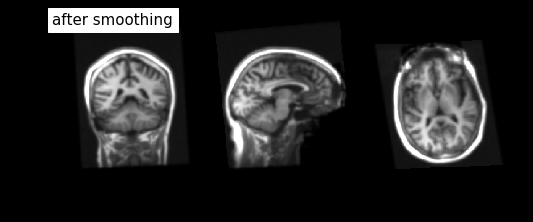

In [2]:
# we will be using plot_anat from nilearn package
%matplotlib inline
from nilearn.plotting import plot_anat
plot_anat('/output/T1w_nipype_smooth.nii.gz', title='after smoothing',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)